# Libraries

In [1]:
# default libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LinearRegression
import time
import math

In [2]:
# plotting configuration
sns.set(style = 'darkgrid',
        font_scale = 1.4,
        rc = {"lines.linewidth": 2,
          "figure.figsize": (12, 8)})

sns.set_palette('Set2')

In [3]:
from tools import get_exponential_bins, compute_quantile_hist_data, compute_interval_score
from hyp_tests import percentile_bootstrap_ci_ratio_cookie_buckets, bc_a_bootstrap_ratio_cookie_buckets,\
jackknife_cookie_bucket_quantile_bucketed
from data_gen import generate_raw_data_lognormal, generate_raw_data_exponential,\
generate_raw_data,get_binned_data_cookie_bucket_level, generate_data_mixture_exp_bucket_level
from hyp_tests import compute_pseudovals_jackknife
from scipy.stats import shapiro

# Simulations (median)

## Mixture / corrupted cookie bucket

### Number of corrupted buckets scales with number of cookie buckets

In [9]:
bins_boundaries= get_exponential_bins(10,600000,100)
num_of_cookie_buckets=20

In [10]:
num_of_sims=2000
threshold=0.001

In [11]:
cand_num_of_cookie_buckets = np.arange(10,110,step=10).tolist()

In [7]:
p_vals_shapiro_50=list()
rej_results_shapiro_50=list()

In [8]:
for cookie_bucket in cand_num_of_cookie_buckets:
    p_vals_shapiro_50 +=[[]]
    rej_results_shapiro_50 +=[[]]

In [9]:
for cur_ind, cur_num_of_cookie_buckets in enumerate(cand_num_of_cookie_buckets):
    for i in range(num_of_sims):
        dataset_treat, dataset_control=generate_data_mixture_exp_bucket_level([1000,1000],[300,600],[0.1,0.9],cur_num_of_cookie_buckets,bins_boundaries)

        # bin raw data and place the clients into cookie buckets
        bucketed_data_treat = pd.DataFrame(dataset_treat)
        bucketed_data_control = pd.DataFrame(dataset_control)
        
        #compute pseudovalues
        pseudo_vals = compute_pseudovals_jackknife(bucketed_data_treat,bucketed_data_control,bins_boundaries,0.5)
        #perform normality test
        p_val = shapiro(pseudo_vals)[1]
        #store results
        p_vals_shapiro_50[cur_ind] +=[p_val]
        if p_val <= threshold:
            rej_results_shapiro_50[cur_ind]+=[1]
        else:
            rej_results_shapiro_50[cur_ind]+=[0]

In [10]:
avg_rej_res_mixture_scaling_50 = np.array([np.mean(cur_num_of_cookie_buckets) for cur_num_of_cookie_buckets in rej_results_shapiro_50])
std_rej_res_mixture_scaling_50 = np.array([np.std(cur_num_of_cookie_buckets) / np.sqrt(num_of_sims) for cur_num_of_cookie_buckets in rej_results_shapiro_50])

Text(0.5, 1.0, 'Average rejection rate')

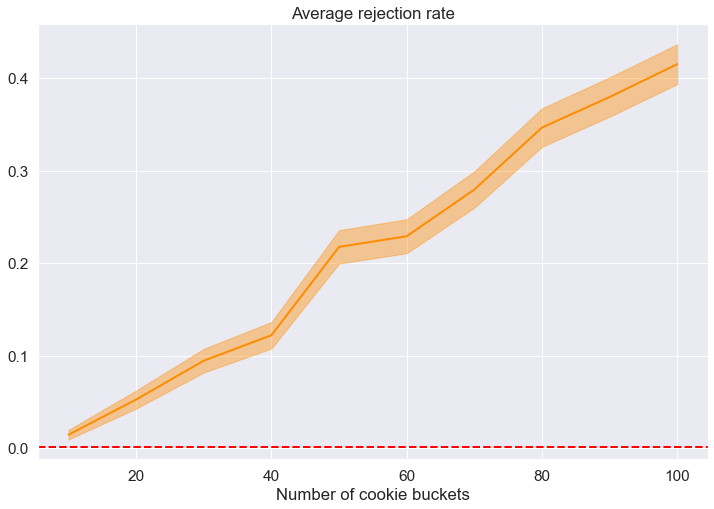

In [11]:
plt.plot(cand_num_of_cookie_buckets, avg_rej_res_mixture_scaling_50, color='DarkOrange')

plt.fill_between(cand_num_of_cookie_buckets,avg_rej_res_mixture_scaling_50 - 1.96 * std_rej_res_mixture_scaling_50,
    avg_rej_res_mixture_scaling_50 + 1.96*std_rej_res_mixture_scaling_50, color='DarkOrange', alpha=0.4)


plt.axhline(threshold, color='red', linestyle='dashed')
plt.xlabel('Number of cookie buckets')
plt.title('Average rejection rate')

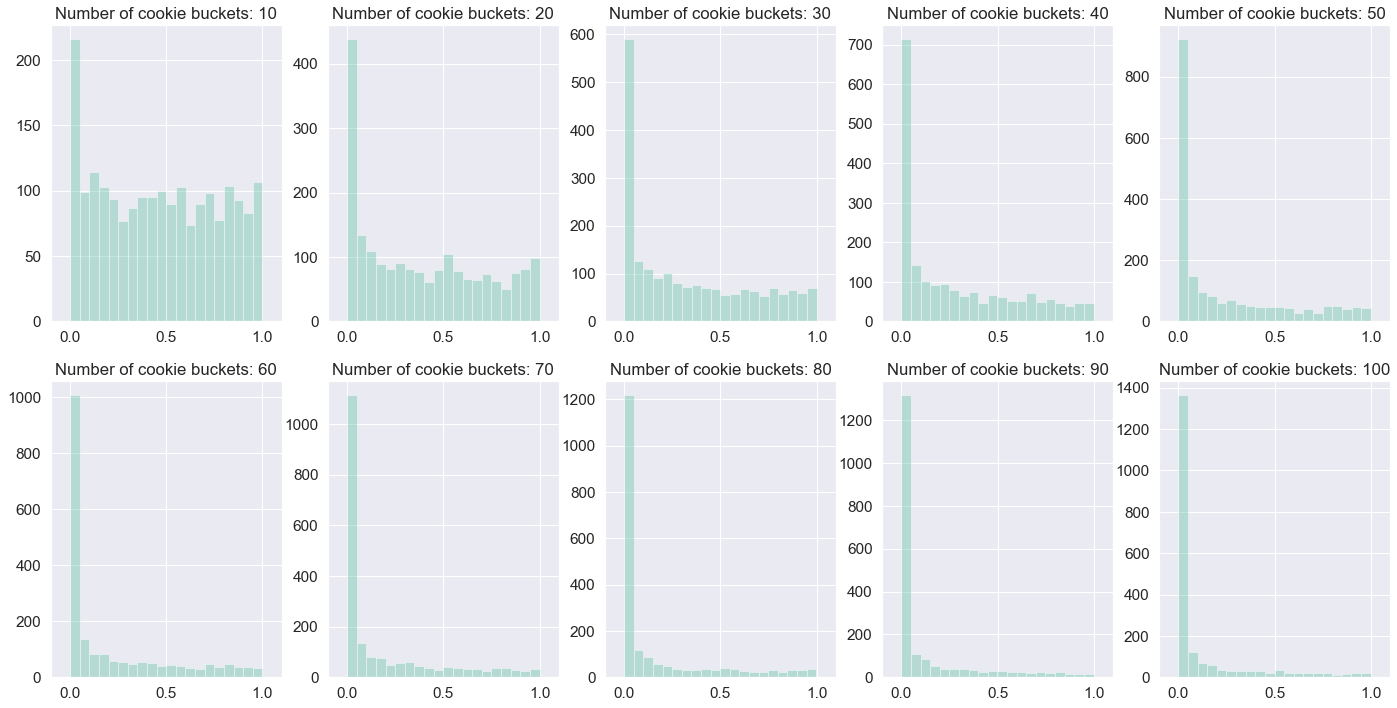

In [12]:
plt.figure(figsize=[24,12])
for i, cur_number_of_buckets in enumerate(cand_num_of_cookie_buckets):
    plt.subplot(2, 5, i+1).set_title('Number of cookie buckets: ' + str(cur_number_of_buckets))
    sns.distplot(p_vals_shapiro_50[i],bins=20,norm_hist=False, kde=False)
    plt.xlim([-0.1,1.1])


## Lognormal case (median)

In [13]:
lognormal_p_vals_shapiro_50=list()
lognormal_rej_results_shapiro_50=list()
for cookie_bucket in cand_num_of_cookie_buckets:
    lognormal_p_vals_shapiro_50 +=[[]]
    lognormal_rej_results_shapiro_50 +=[[]]

In [14]:
for cur_ind, cur_num_of_cookie_buckets in enumerate(cand_num_of_cookie_buckets):
    for i in range(num_of_sims):
        raw_data_treatment = generate_raw_data_lognormal(number_of_users = 1000, mean_param=7,sigma_param=1)
        raw_data_control = generate_raw_data_lognormal(number_of_users = 1000, mean_param=7,sigma_param=1)

        # bin raw data and place the clients into cookie buckets
        bucketed_data_treat = get_binned_data_cookie_bucket_level(raw_data_treatment,cur_num_of_cookie_buckets, bins_boundaries)
        bucketed_data_control = get_binned_data_cookie_bucket_level(raw_data_control,cur_num_of_cookie_buckets, bins_boundaries)
        
        #compute pseudovalues
        pseudo_vals = compute_pseudovals_jackknife(bucketed_data_treat,bucketed_data_control,bins_boundaries,0.5)
        
        #perform normality test
        p_val = shapiro(pseudo_vals)[1]
        
        #store results
        lognormal_p_vals_shapiro_50[cur_ind] +=[p_val]
        if p_val <= threshold:
            lognormal_rej_results_shapiro_50[cur_ind]+=[1]
        else:
            lognormal_rej_results_shapiro_50[cur_ind]+=[0]

In [15]:
lognormal_avg_rej_res_mixture_scaling_50 = np.array([np.mean(cur_num_of_cookie_buckets) for cur_num_of_cookie_buckets in lognormal_rej_results_shapiro_50])
lognormal_std_rej_res_mixture_scaling_50 = np.array([np.std(cur_num_of_cookie_buckets)/np.sqrt(num_of_sims) for cur_num_of_cookie_buckets in lognormal_rej_results_shapiro_50])

Text(0.5, 1.0, 'Average rejection rate')

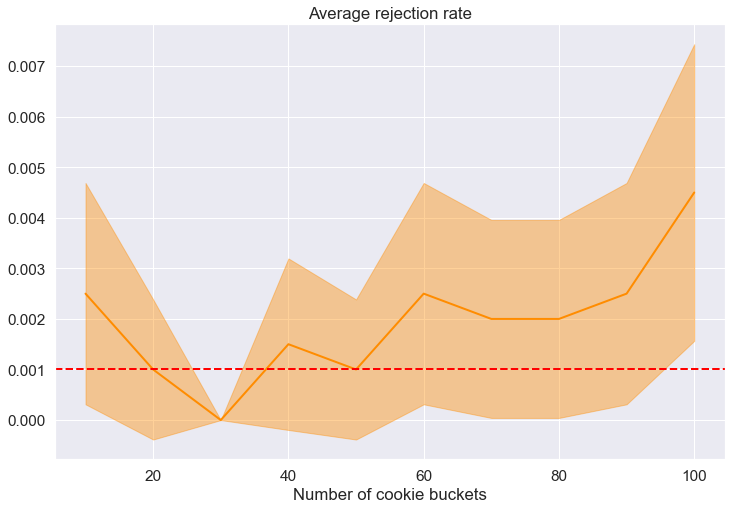

In [16]:
plt.plot(cand_num_of_cookie_buckets, lognormal_avg_rej_res_mixture_scaling_50, color='DarkOrange')

plt.fill_between(cand_num_of_cookie_buckets,lognormal_avg_rej_res_mixture_scaling_50 - 1.96 * lognormal_std_rej_res_mixture_scaling_50,
    lognormal_avg_rej_res_mixture_scaling_50 + 1.96*lognormal_std_rej_res_mixture_scaling_50, color='DarkOrange', alpha=0.4)


plt.axhline(threshold, color='red', linestyle='dashed')
plt.xlabel('Number of cookie buckets')
plt.title('Average rejection rate')

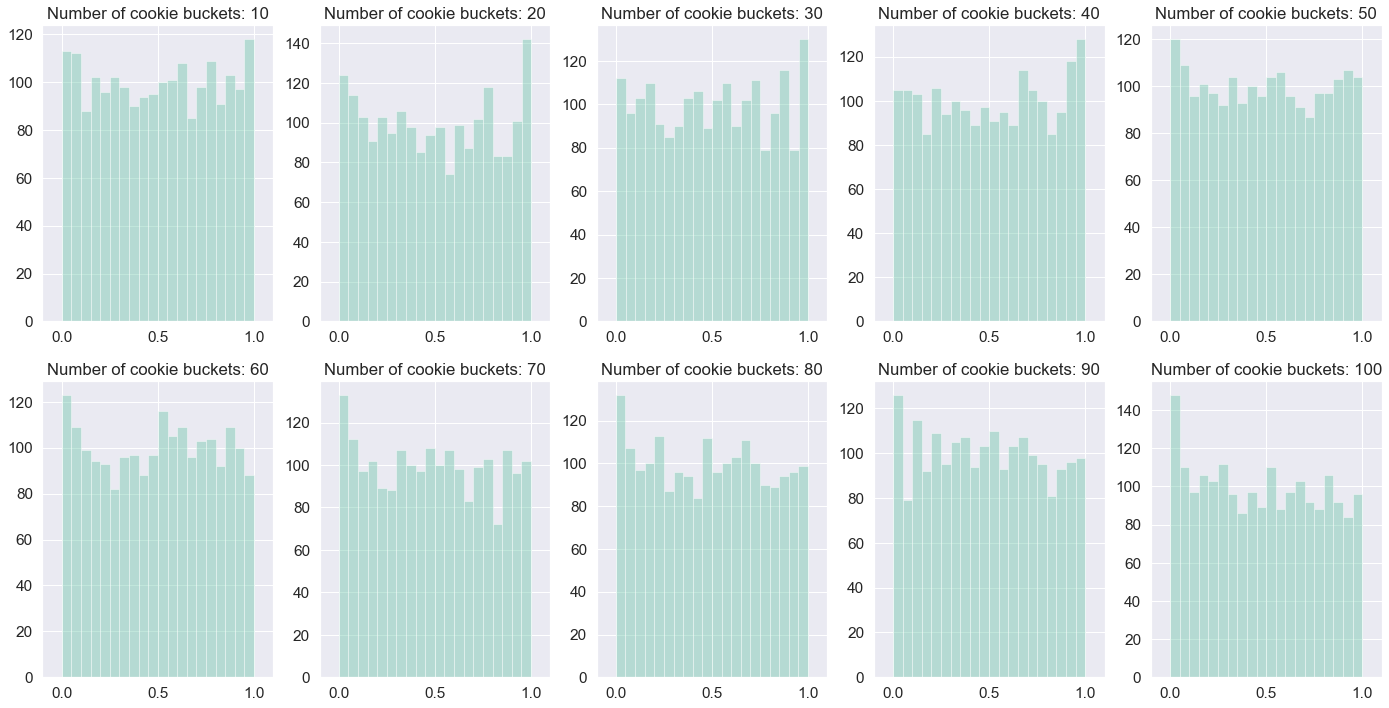

In [39]:
plt.figure(figsize=[24,12])
for i, cur_number_of_buckets in enumerate(cand_num_of_cookie_buckets):
    plt.subplot(2, 5, i+1).set_title('Number of cookie buckets: {:d}'.format(cur_number_of_buckets))
    sns.distplot(lognormal_p_vals_shapiro_50[i],bins=20,norm_hist=False, kde=False)
    plt.xlim([-0.1,1.1])
plt.savefig('normality_50.pdf',bbox_inches='tight')


## Exponential case

In [18]:
exp_p_vals_shapiro_50=list()
exp_rej_results_shapiro_50=list()

In [19]:
for cookie_bucket in cand_num_of_cookie_buckets:
    exp_p_vals_shapiro_50 +=[[]]
    exp_rej_results_shapiro_50 +=[[]]

In [20]:
for cur_ind, cur_num_of_cookie_buckets in enumerate(cand_num_of_cookie_buckets):
    for i in range(num_of_sims):
        raw_data_treatment = generate_raw_data_exponential(number_of_users = 1000, scale_param=500)
        raw_data_control = generate_raw_data_exponential(number_of_users = 1000, scale_param=500)

        # bin raw data and place the clients into cookie buckets
        bucketed_data_treat = get_binned_data_cookie_bucket_level(raw_data_treatment,cur_num_of_cookie_buckets, bins_boundaries)
        bucketed_data_control = get_binned_data_cookie_bucket_level(raw_data_control,cur_num_of_cookie_buckets, bins_boundaries)
        
        #compute pseudovalues
        pseudo_vals = compute_pseudovals_jackknife(bucketed_data_treat,bucketed_data_control,bins_boundaries,0.5)
        #perform normality test
        p_val = shapiro(pseudo_vals)[1]
        #store results
        exp_p_vals_shapiro_50[cur_ind] +=[p_val]
        if p_val <= threshold:
            exp_rej_results_shapiro_50[cur_ind]+=[1]
        else:
            exp_rej_results_shapiro_50[cur_ind]+=[0]

In [21]:
exp_avg_rej_res_mixture_scaling_50 = np.array([np.mean(cur_num_of_cookie_buckets) for cur_num_of_cookie_buckets in exp_rej_results_shapiro_50])
exp_std_rej_res_mixture_scaling_50 = np.array([np.std(cur_num_of_cookie_buckets)/np.sqrt(num_of_sims) for cur_num_of_cookie_buckets in exp_rej_results_shapiro_50])

Text(0.5, 1.0, 'Average rejection rate')

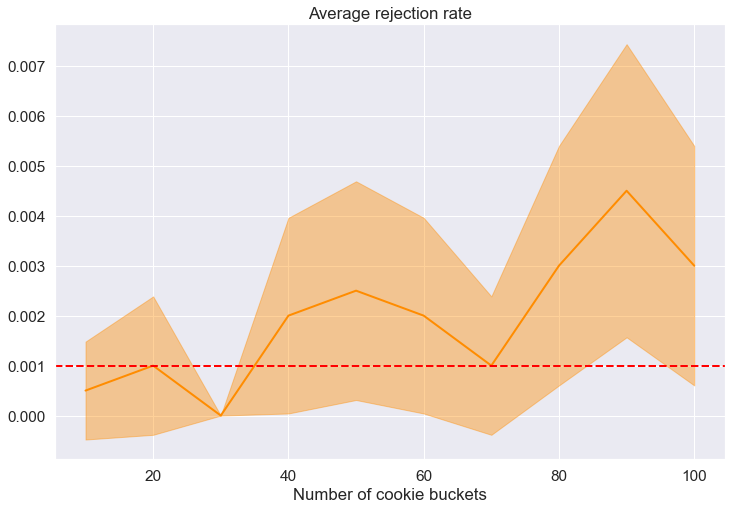

In [22]:
plt.plot(cand_num_of_cookie_buckets, exp_avg_rej_res_mixture_scaling_50, color='DarkOrange')

plt.fill_between(cand_num_of_cookie_buckets,exp_avg_rej_res_mixture_scaling_50 - 1.96 * exp_std_rej_res_mixture_scaling_50,
    exp_avg_rej_res_mixture_scaling_50 + 1.96*exp_std_rej_res_mixture_scaling_50, color='DarkOrange', alpha=0.4)


plt.axhline(threshold, color='red', linestyle='dashed')
plt.xlabel('Number of cookie buckets')
plt.title('Average rejection rate')

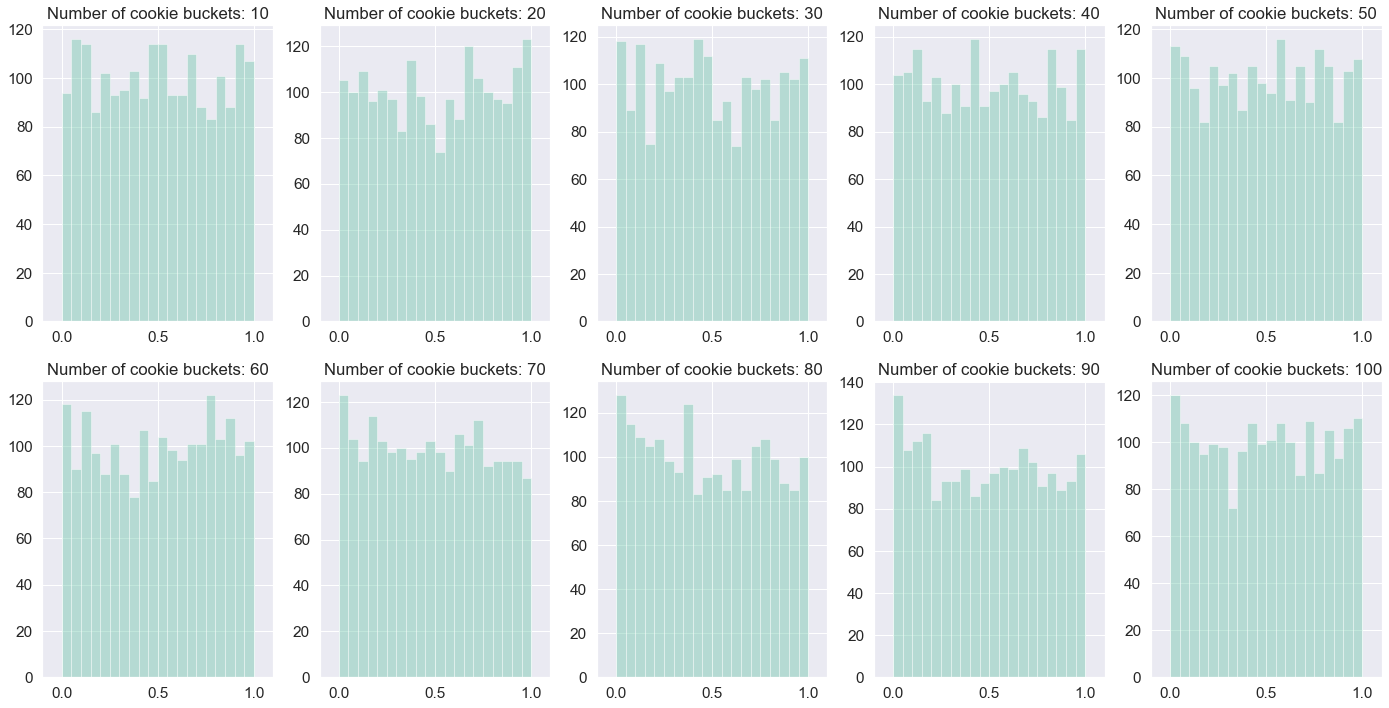

In [23]:
plt.figure(figsize=[24,12])
for i, cur_number_of_buckets in enumerate(cand_num_of_cookie_buckets):
    plt.subplot(2, 5, i+1).set_title('Number of cookie buckets: {:d}'.format(cur_number_of_buckets))
    sns.distplot(exp_p_vals_shapiro_50[i],bins=20,norm_hist=False, kde=False)
    plt.xlim([-0.1,1.1])


# Simulations (higher percentile: 95th for lognormal case)

In [24]:
lognormal_p_vals_shapiro_95=list()
lognormal_rej_results_shapiro_95=list()
for cookie_bucket in cand_num_of_cookie_buckets:
    lognormal_p_vals_shapiro_95 +=[[]]
    lognormal_rej_results_shapiro_95 +=[[]]

In [25]:
for cur_ind, cur_num_of_cookie_buckets in enumerate(cand_num_of_cookie_buckets):
    for i in range(num_of_sims):
        raw_data_treatment = generate_raw_data_lognormal(number_of_users = 1000, mean_param=7,sigma_param=1)
        raw_data_control = generate_raw_data_lognormal(number_of_users = 1000, mean_param=7,sigma_param=1)

        # bin raw data and place the clients into cookie buckets
        bucketed_data_treat = get_binned_data_cookie_bucket_level(raw_data_treatment,cur_num_of_cookie_buckets, bins_boundaries)
        bucketed_data_control = get_binned_data_cookie_bucket_level(raw_data_control,cur_num_of_cookie_buckets, bins_boundaries)
        
        #compute pseudovalues
        pseudo_vals = compute_pseudovals_jackknife(bucketed_data_treat,bucketed_data_control,bins_boundaries,0.95)
        #perform normality test
        p_val = shapiro(pseudo_vals)[1]
        #store results
        lognormal_p_vals_shapiro_95[cur_ind] +=[p_val]
        if p_val <= threshold:
            lognormal_rej_results_shapiro_95[cur_ind]+=[1]
        else:
            lognormal_rej_results_shapiro_95[cur_ind]+=[0]

In [26]:
lognormal_avg_rej_res_mixture_scaling_95 = np.array([np.mean(cur_num_of_cookie_buckets) for cur_num_of_cookie_buckets in lognormal_rej_results_shapiro_95])
lognormal_std_rej_res_mixture_scaling_95 = np.array([np.std(cur_num_of_cookie_buckets)/np.sqrt(num_of_sims) for cur_num_of_cookie_buckets in lognormal_rej_results_shapiro_95])

Text(0.5, 1.0, 'Average rejection rate')

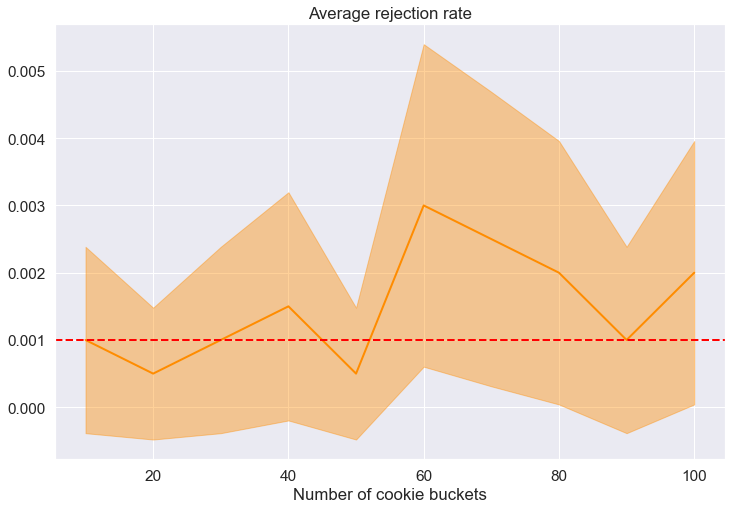

In [27]:
plt.plot(cand_num_of_cookie_buckets, lognormal_avg_rej_res_mixture_scaling_95, color='DarkOrange')

plt.fill_between(cand_num_of_cookie_buckets,lognormal_avg_rej_res_mixture_scaling_95 - 1.96 * lognormal_std_rej_res_mixture_scaling_95,
    lognormal_avg_rej_res_mixture_scaling_95 + 1.96*lognormal_std_rej_res_mixture_scaling_95, color='DarkOrange', alpha=0.4)


plt.axhline(threshold, color='red', linestyle='dashed')
plt.xlabel('Number of cookie buckets')
plt.title('Average rejection rate')

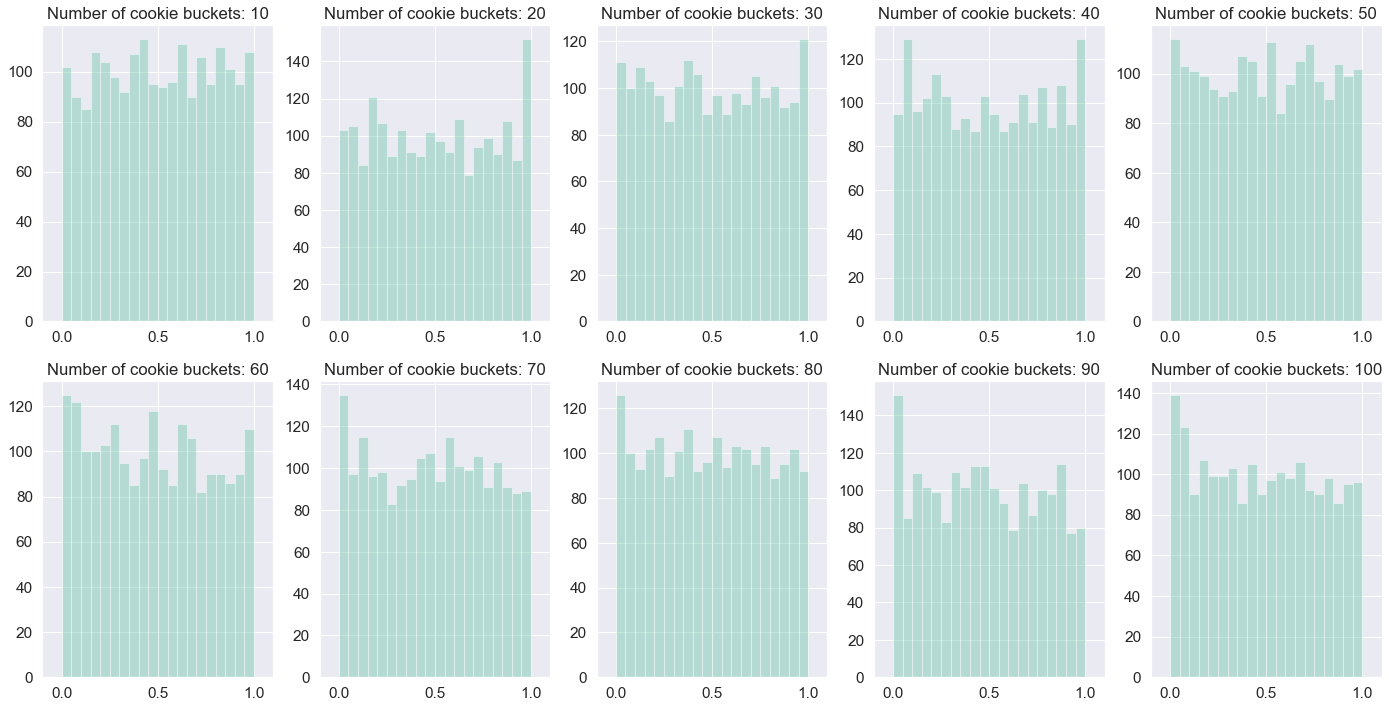

In [40]:
plt.figure(figsize=[24,12])
for i, cur_number_of_buckets in enumerate(cand_num_of_cookie_buckets):
    plt.subplot(2, 5, i+1).set_title('Number of cookie buckets: {:d}'.format(cur_number_of_buckets))
    sns.distplot(lognormal_p_vals_shapiro_95[i],bins=20,norm_hist=False, kde=False)
    plt.xlim([-0.1,1.1])

plt.savefig('normality_95.pdf',bbox_inches='tight')


# Simulations (higher percentile: 99th for lognormal case)

In [29]:
lognormal_p_vals_shapiro_99=list()
lognormal_rej_results_shapiro_99=list()
for cookie_bucket in cand_num_of_cookie_buckets:
    lognormal_p_vals_shapiro_99 +=[[]]
    lognormal_rej_results_shapiro_99 +=[[]]

In [30]:
for cur_ind, cur_num_of_cookie_buckets in enumerate(cand_num_of_cookie_buckets):
    for i in range(num_of_sims):
        raw_data_treatment = generate_raw_data_lognormal(number_of_users = 1000, mean_param=7, sigma_param=1)
        raw_data_control = generate_raw_data_lognormal(number_of_users = 1000, mean_param=7, sigma_param=1)

        # bin raw data and place the clients into cookie buckets
        bucketed_data_treat = get_binned_data_cookie_bucket_level(raw_data_treatment,cur_num_of_cookie_buckets, bins_boundaries)
        bucketed_data_control = get_binned_data_cookie_bucket_level(raw_data_control,cur_num_of_cookie_buckets, bins_boundaries)
        
        #compute pseudovalues
        pseudo_vals = compute_pseudovals_jackknife(bucketed_data_treat,bucketed_data_control,bins_boundaries,0.99)
        #perform normality test
        p_val = shapiro(pseudo_vals)[1]
        #store results
        lognormal_p_vals_shapiro_99[cur_ind] +=[p_val]
        if p_val <= threshold:
            lognormal_rej_results_shapiro_99[cur_ind]+=[1]
        else:
            lognormal_rej_results_shapiro_99[cur_ind]+=[0]

In [31]:
lognormal_avg_rej_res_mixture_scaling_99 = np.array([np.mean(cur_num_of_cookie_buckets) for cur_num_of_cookie_buckets in lognormal_rej_results_shapiro_99])
lognormal_std_rej_res_mixture_scaling_99 = np.array([np.std(cur_num_of_cookie_buckets)/np.sqrt(num_of_sims) for cur_num_of_cookie_buckets in lognormal_rej_results_shapiro_99])

Text(0.5, 1.0, 'Average rejection rate')

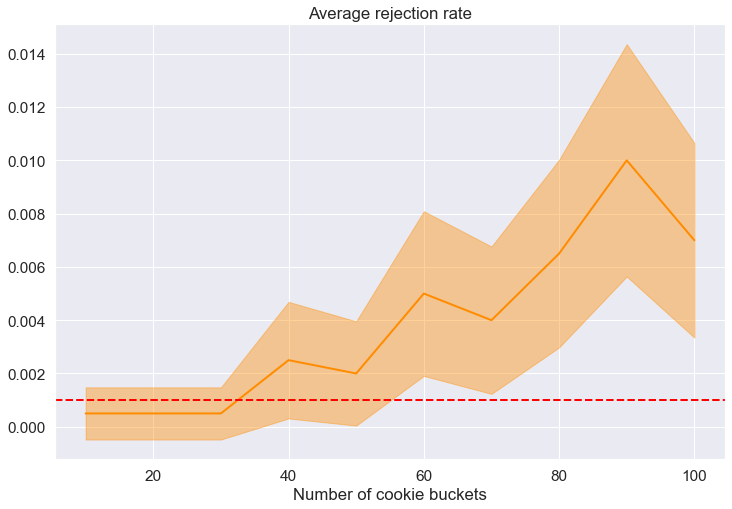

In [32]:
plt.plot(cand_num_of_cookie_buckets, lognormal_avg_rej_res_mixture_scaling_99, color='DarkOrange')

plt.fill_between(cand_num_of_cookie_buckets,lognormal_avg_rej_res_mixture_scaling_99 - 1.96 * lognormal_std_rej_res_mixture_scaling_99,
    lognormal_avg_rej_res_mixture_scaling_99 + 1.96*lognormal_std_rej_res_mixture_scaling_99, color='DarkOrange', alpha=0.4)


plt.axhline(threshold, color='red', linestyle='dashed')
plt.xlabel('Number of cookie buckets')
plt.title('Average rejection rate')

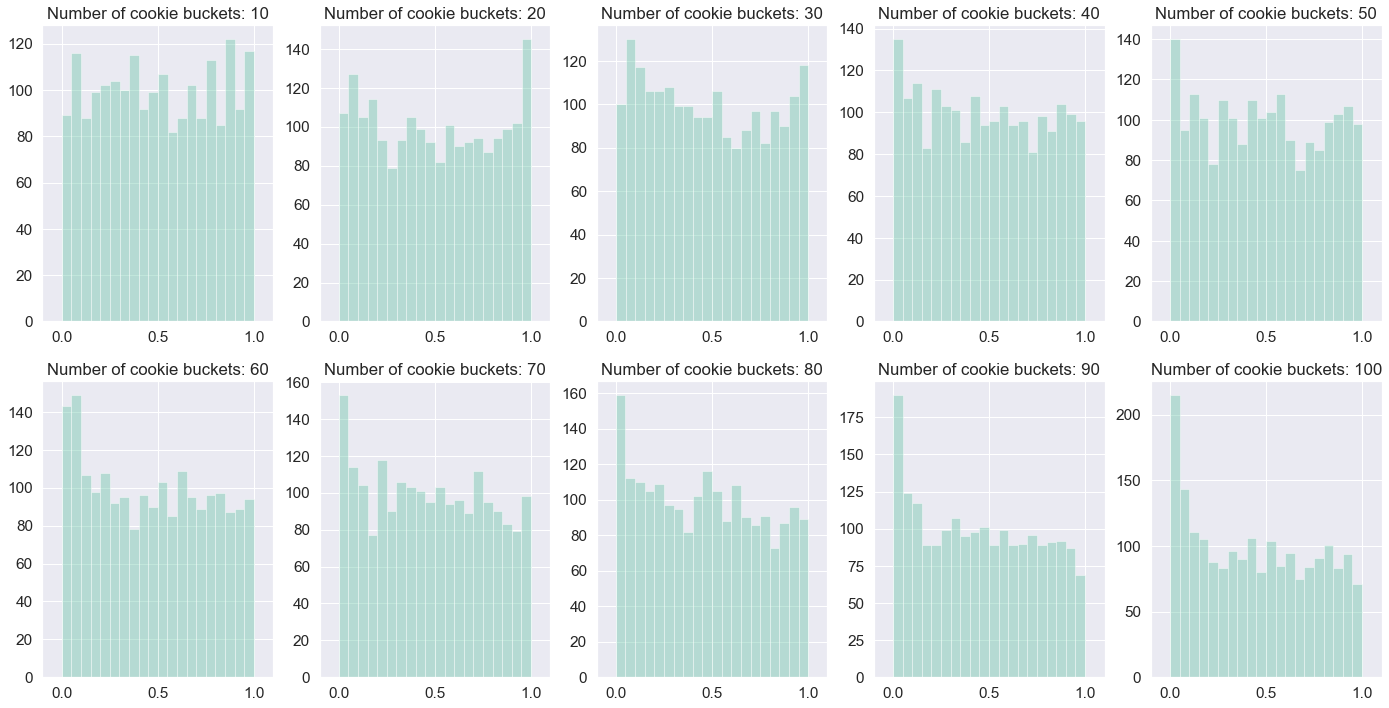

In [41]:
plt.figure(figsize=[24,12])
for i, cur_number_of_buckets in enumerate(cand_num_of_cookie_buckets):
    plt.subplot(2, 5, i+1).set_title('Number of cookie buckets: {:d}'.format(cur_number_of_buckets))
    sns.distplot(lognormal_p_vals_shapiro_99[i],bins=20,norm_hist=False, kde=False)
    plt.xlim([-0.1,1.1])

plt.savefig('normality_99.pdf',bbox_inches='tight')


## Simulations (changing number of observations for fixed number of cookie buckets/lognormal case)

In [34]:
cand_num_of_clients = np.linspace(100,1200,10).astype('int')

In [35]:
cand_num_of_clients

array([ 100,  222,  344,  466,  588,  711,  833,  955, 1077, 1200])

In [36]:
varying_num_of_clients_p_vals_shapiro_50=list()
varying_num_of_clients_rej_results_shapiro_50=list()
varying_num_of_clients_min_num_of_points_bucket_50 = list()
varying_num_of_clients_max_num_of_points_bucket_50 = list()
varying_num_of_clients_avg_num_of_points_bucket_50 = list()
varying_num_of_clients_total_num_of_points_bucket_50 = list()
for cookie_bucket in cand_num_of_clients:
    varying_num_of_clients_p_vals_shapiro_50 +=[[]]
    varying_num_of_clients_rej_results_shapiro_50 +=[[]]
    varying_num_of_clients_min_num_of_points_bucket_50+=[[]]
    varying_num_of_clients_max_num_of_points_bucket_50+=[[]]
    varying_num_of_clients_avg_num_of_points_bucket_50+=[[]]
    varying_num_of_clients_total_num_of_points_bucket_50+=[[]]

In [37]:
num_of_sims = 1000

In [38]:
for cur_ind, cur_num_of_clients in enumerate(cand_num_of_clients):
    for i in range(num_of_sims):
        raw_data_treatment = generate_raw_data_lognormal(number_of_users = cur_num_of_clients, mean_param=7, sigma_param=1)
        raw_data_control = generate_raw_data_lognormal(number_of_users = cur_num_of_clients, mean_param=7, sigma_param=1)

        # bin raw data and place the clients into cookie buckets
        bucketed_data_treat = get_binned_data_cookie_bucket_level(raw_data_treatment, 20, bins_boundaries)
        bucketed_data_control = get_binned_data_cookie_bucket_level(raw_data_control, 20, bins_boundaries)
        
        varying_num_of_clients_min_num_of_points_bucket_50[cur_ind]+=[(bucketed_data_treat.sum(axis=1).min(),bucketed_data_control.sum(axis=1).min())]
        varying_num_of_clients_max_num_of_points_bucket_50[cur_ind]+=[(bucketed_data_treat.sum(axis=1).max(),bucketed_data_control.sum(axis=1).max())]
        varying_num_of_clients_avg_num_of_points_bucket_50[cur_ind]+=[(bucketed_data_treat.sum(axis=1).mean(),bucketed_data_control.sum(axis=1).mean())]
        varying_num_of_clients_total_num_of_points_bucket_50[cur_ind]+=[bucketed_data_treat.sum(axis=0).sum()]
        #compute pseudovalues
        pseudo_vals = compute_pseudovals_jackknife(bucketed_data_treat,bucketed_data_control,bins_boundaries,0.99)
        #perform normality test
        p_val = shapiro(pseudo_vals)[1]
        #store results
        varying_num_of_clients_p_vals_shapiro_50[cur_ind] +=[p_val]
        if p_val <= threshold:
            varying_num_of_clients_rej_results_shapiro_50[cur_ind]+=[1]
        else:
            varying_num_of_clients_rej_results_shapiro_50[cur_ind]+=[0]

In [42]:
avg_varying_rej_rate_50 = np.array([np.mean(cur_num_of_cookie_buckets) for cur_num_of_cookie_buckets in varying_num_of_clients_rej_results_shapiro_50])
std_varying_rej_rate_50 = np.array([np.std(cur_num_of_cookie_buckets)/np.sqrt(num_of_sims) for cur_num_of_cookie_buckets in varying_num_of_clients_rej_results_shapiro_50])

avg_varying_num_of_obs_50 = np.array([np.mean(cur_num_of_cookie_buckets) for cur_num_of_cookie_buckets in varying_num_of_clients_total_num_of_points_bucket_50])
std_varying_num_of_obs_50 = np.array([np.std(cur_num_of_cookie_buckets)/np.sqrt(num_of_sims) for cur_num_of_cookie_buckets in varying_num_of_clients_total_num_of_points_bucket_50])

avg_varying_min_50 = np.array([np.mean(cur_num_of_cookie_buckets) for cur_num_of_cookie_buckets in varying_num_of_clients_min_num_of_points_bucket_50])
std_varying_min_50 = np.array([np.std(cur_num_of_cookie_buckets)/np.sqrt(num_of_sims) for cur_num_of_cookie_buckets in varying_num_of_clients_min_num_of_points_bucket_50])

avg_varying_max_50 = np.array([np.mean(cur_num_of_cookie_buckets) for cur_num_of_cookie_buckets in varying_num_of_clients_max_num_of_points_bucket_50])
std_varying_max_50 = np.array([np.std(cur_num_of_cookie_buckets)/np.sqrt(num_of_sims) for cur_num_of_cookie_buckets in varying_num_of_clients_max_num_of_points_bucket_50])

avg_varying_mean_50 = np.array([np.mean(cur_num_of_cookie_buckets) for cur_num_of_cookie_buckets in varying_num_of_clients_avg_num_of_points_bucket_50])
std_varying_mean_50 = np.array([np.std(cur_num_of_cookie_buckets)/np.sqrt(num_of_sims) for cur_num_of_cookie_buckets in varying_num_of_clients_avg_num_of_points_bucket_50])

avg_varying_total_50 = np.array([np.mean(cur_num_of_cookie_buckets) for cur_num_of_cookie_buckets in varying_num_of_clients_total_num_of_points_bucket_50])
std_varying_total_50 = np.array([np.std(cur_num_of_cookie_buckets)/np.sqrt(num_of_sims) for cur_num_of_cookie_buckets in varying_num_of_clients_total_num_of_points_bucket_50])

Text(0.5, 1.0, 'Average rejection rate')

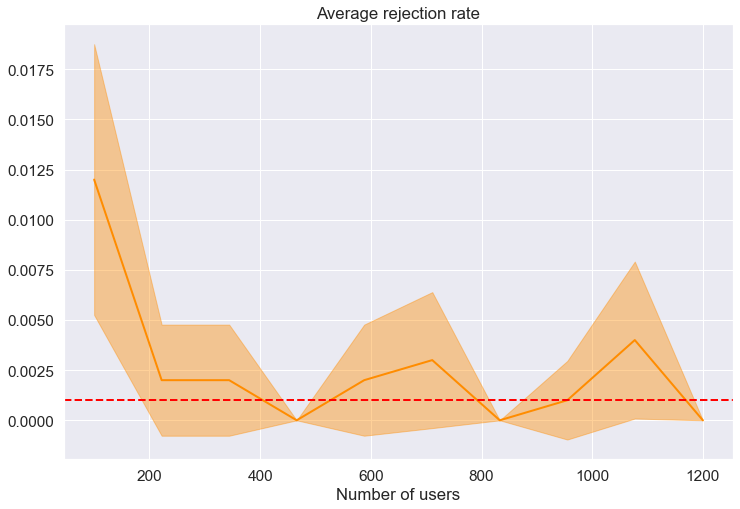

In [43]:
plt.plot(cand_num_of_clients, avg_varying_rej_rate_50, color='DarkOrange')

plt.fill_between(cand_num_of_clients,avg_varying_rej_rate_50 - 1.96 * std_varying_rej_rate_50,
    avg_varying_rej_rate_50 + 1.96*std_varying_rej_rate_50, color='DarkOrange', alpha=0.4)


plt.axhline(threshold, color='red', linestyle='dashed')
plt.xlabel('Number of users')
plt.title('Average rejection rate')

Text(0.5, 1.0, 'Average rejection rate')

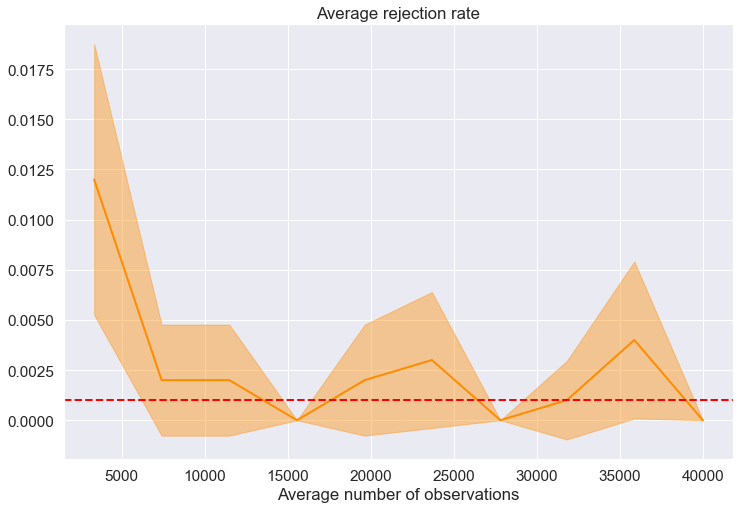

In [44]:
plt.plot(avg_varying_num_of_obs_50, avg_varying_rej_rate_50, color='DarkOrange')

plt.fill_between(avg_varying_num_of_obs_50,avg_varying_rej_rate_50 - 1.96 * std_varying_rej_rate_50,
    avg_varying_rej_rate_50 + 1.96*std_varying_rej_rate_50, color='DarkOrange', alpha=0.4)

plt.axhline(threshold, color='red', linestyle='dashed')
plt.xlabel('Average number of observations')
plt.title('Average rejection rate')

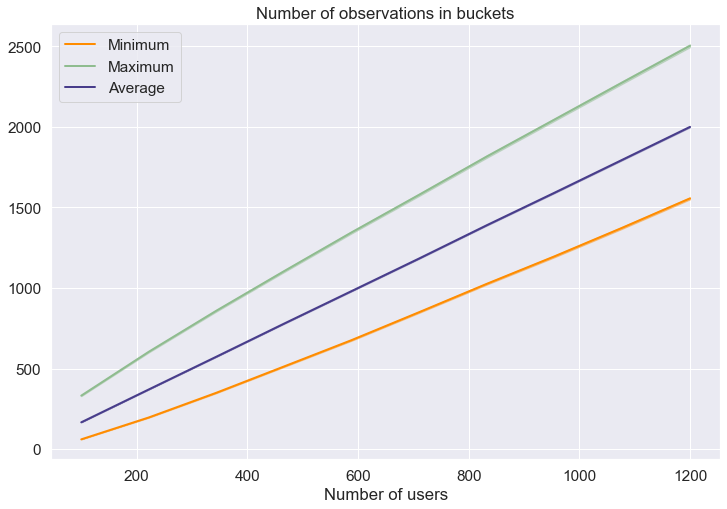

In [45]:
plt.plot(cand_num_of_clients, avg_varying_min_50 , color='DarkOrange', label='Minimum')

plt.fill_between(cand_num_of_clients,avg_varying_min_50  - 1.96 * std_varying_min_50 ,
    avg_varying_min_50  + 1.96*std_varying_min_50 , color='DarkOrange', alpha=0.4)

plt.plot(cand_num_of_clients, avg_varying_max_50 , color='DarkSeaGreen', label='Maximum')

plt.fill_between(cand_num_of_clients,avg_varying_max_50  - 1.96 * std_varying_max_50 ,
    avg_varying_max_50  + 1.96*std_varying_max_50 , color='DarkSeaGreen', alpha=0.4)

plt.plot(cand_num_of_clients, avg_varying_mean_50 , color='darkslateblue', label='Average')

plt.fill_between(cand_num_of_clients,avg_varying_mean_50  - 1.96 * std_varying_mean_50 ,
    avg_varying_mean_50  + 1.96*std_varying_mean_50 , color='darkslateblue', alpha=0.4)


plt.xlabel('Number of users')
plt.title('Number of observations in buckets')
plt.legend()
plt.show()

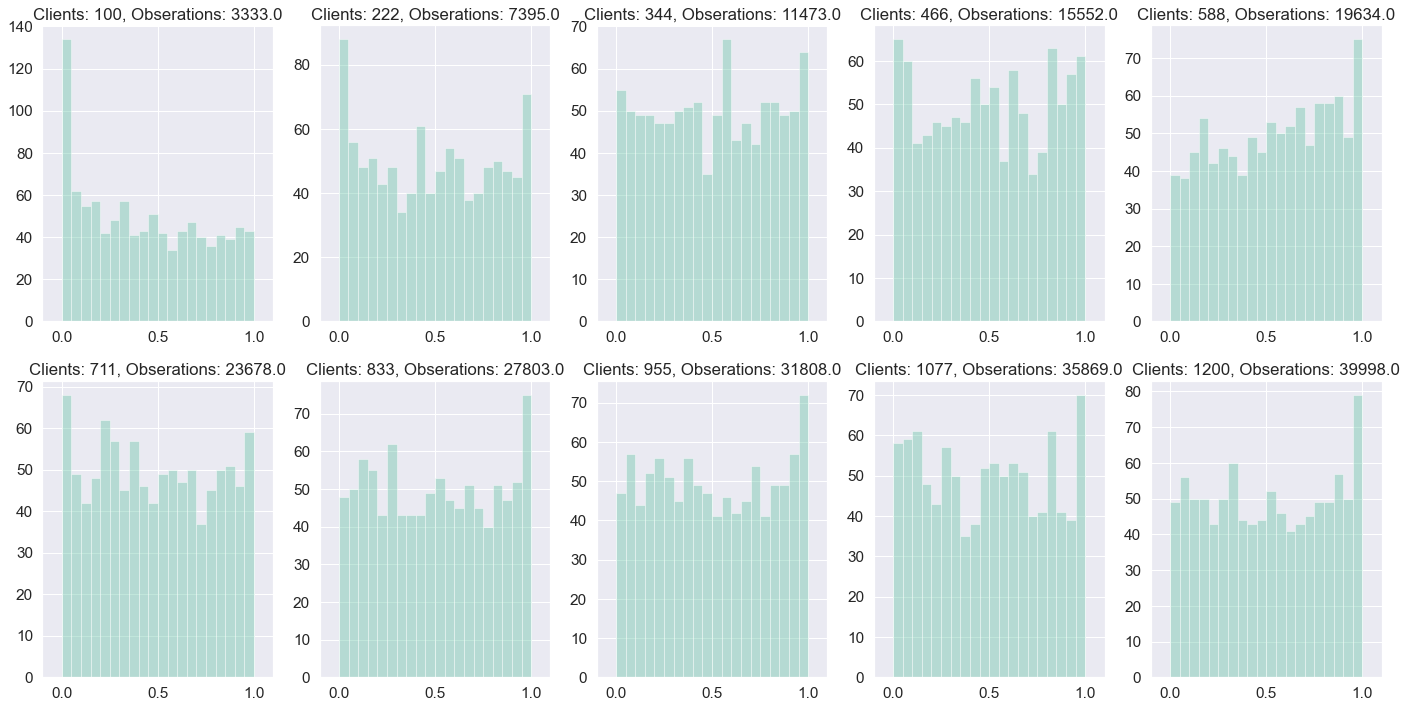

In [47]:
plt.figure(figsize=[24,12])
for i, cur_number_of_users in enumerate(cand_num_of_clients):
    plt.subplot(2, 5, i+1).set_title('Number of cookie buckets: {:d}'.format(cur_number_of_buckets))
    sns.distplot(varying_num_of_clients_p_vals_shapiro_50[i],bins=20,norm_hist=False, kde=False)
    plt.xlim([-0.1,1.1])

plt.savefig('normality_clients_20_cb.pdf',bbox_inches='tight')


## One corrupted bucket

In [4]:
from data_gen import generate_data_single_corrupted_exp_bucket_level

In [12]:
num_of_sims=1000

In [13]:
one_cor_p_vals_shapiro_50=list()
one_cor_rej_results_shapiro_50=list()

In [14]:
for cookie_bucket in cand_num_of_cookie_buckets:
    one_cor_p_vals_shapiro_50 +=[[]]
    one_cor_rej_results_shapiro_50 +=[[]]

In [15]:
for cur_ind, cur_num_of_cookie_buckets in enumerate(cand_num_of_cookie_buckets):
    for i in range(num_of_sims):
        dataset_treat, dataset_control=generate_data_single_corrupted_exp_bucket_level([1000,1000],[600,300],cur_num_of_cookie_buckets,bins_boundaries)

        # bin raw data and place the clients into cookie buckets
        bucketed_data_treat = pd.DataFrame(dataset_treat)
        bucketed_data_control = pd.DataFrame(dataset_control)
        
        #compute pseudovalues
        pseudo_vals = compute_pseudovals_jackknife(bucketed_data_treat,bucketed_data_control,bins_boundaries,0.5)
        #perform normality test
        p_val = shapiro(pseudo_vals)[1]
        #store results
        one_cor_p_vals_shapiro_50[cur_ind] +=[p_val]
        if p_val <= threshold:
            one_cor_rej_results_shapiro_50[cur_ind]+=[1]
        else:
            one_cor_rej_results_shapiro_50[cur_ind]+=[0]

In [16]:
avg_one_cor_rej_res_mixture_50 = np.array([np.mean(cur_num_of_cookie_buckets) for cur_num_of_cookie_buckets in one_cor_rej_results_shapiro_50])
std_one_cor_rej_res_mixture_50 = np.array([np.std(cur_num_of_cookie_buckets) / np.sqrt(num_of_sims) for cur_num_of_cookie_buckets in one_cor_rej_results_shapiro_50])

Text(0.5, 1.0, 'Average rejection rate')

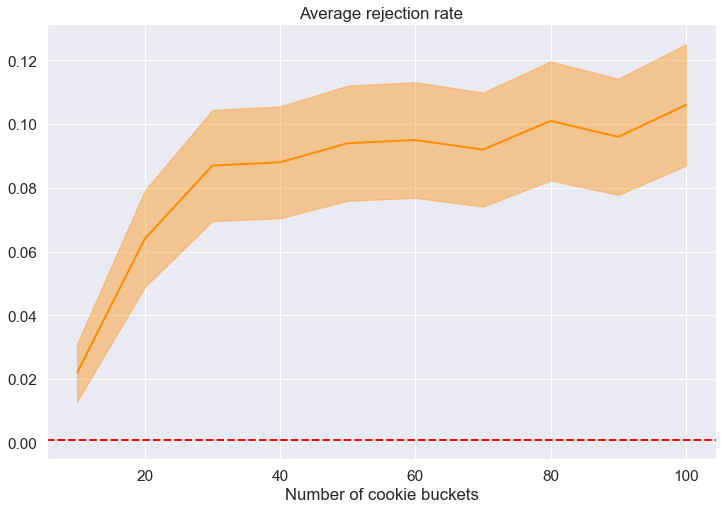

In [17]:
plt.plot(cand_num_of_cookie_buckets, avg_one_cor_rej_res_mixture_50, color='DarkOrange')

plt.fill_between(cand_num_of_cookie_buckets,avg_one_cor_rej_res_mixture_50 - 1.96 * std_one_cor_rej_res_mixture_50,
    avg_one_cor_rej_res_mixture_50 + 1.96*std_one_cor_rej_res_mixture_50, color='DarkOrange', alpha=0.4)


plt.axhline(threshold, color='red', linestyle='dashed')
plt.xlabel('Number of cookie buckets')
plt.title('Average rejection rate')

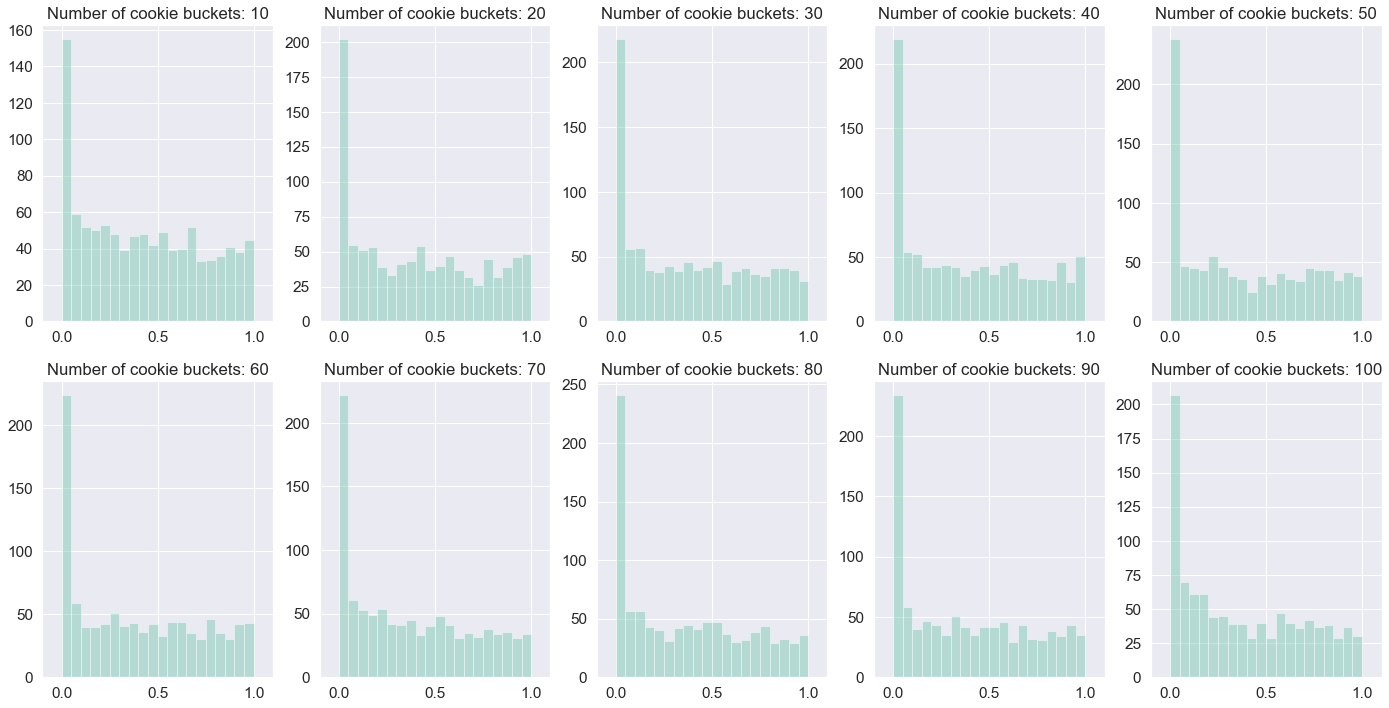

In [33]:
plt.figure(figsize=[24,12])
for i, cur_number_of_buckets in enumerate(cand_num_of_cookie_buckets):
    plt.subplot(2, 5, i+1).set_title('Number of cookie buckets: {:d}'.format(cur_number_of_buckets))
    sns.distplot(one_cor_p_vals_shapiro_50[i],bins=20,norm_hist=False, kde=False)
    plt.xlim([-0.1,1.1])

plt.savefig('normality_one_cor.pdf',bbox_inches='tight')


### One corrupted / 95th percentile

In [19]:
one_cor_p_vals_shapiro_95=list()
one_cor_rej_results_shapiro_95=list()

In [20]:
for cookie_bucket in cand_num_of_cookie_buckets:
    one_cor_p_vals_shapiro_95 +=[[]]
    one_cor_rej_results_shapiro_95 +=[[]]

In [21]:
for cur_ind, cur_num_of_cookie_buckets in enumerate(cand_num_of_cookie_buckets):
    for i in range(num_of_sims):
        dataset_treat, dataset_control=generate_data_single_corrupted_exp_bucket_level([1000,1000],[600,300],cur_num_of_cookie_buckets,bins_boundaries)

        # bin raw data and place the clients into cookie buckets
        bucketed_data_treat = pd.DataFrame(dataset_treat)
        bucketed_data_control = pd.DataFrame(dataset_control)
        
        #compute pseudovalues
        pseudo_vals = compute_pseudovals_jackknife(bucketed_data_treat,bucketed_data_control,bins_boundaries,0.95)
        #perform normality test
        p_val = shapiro(pseudo_vals)[1]
        #store results
        one_cor_p_vals_shapiro_95[cur_ind] +=[p_val]
        if p_val <= threshold:
            one_cor_rej_results_shapiro_95[cur_ind]+=[1]
        else:
            one_cor_rej_results_shapiro_95[cur_ind]+=[0]

In [22]:
avg_one_cor_rej_res_mixture_95 = np.array([np.mean(cur_num_of_cookie_buckets) for cur_num_of_cookie_buckets in one_cor_rej_results_shapiro_95])
std_one_cor_rej_res_mixture_95 = np.array([np.std(cur_num_of_cookie_buckets) / np.sqrt(num_of_sims) for cur_num_of_cookie_buckets in one_cor_rej_results_shapiro_95])

Text(0.5, 1.0, 'Average rejection rate')

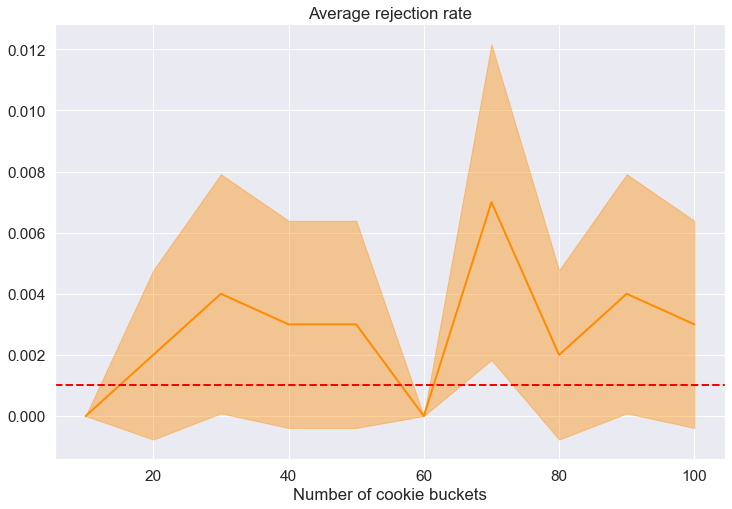

In [23]:
plt.plot(cand_num_of_cookie_buckets, avg_one_cor_rej_res_mixture_95, color='DarkOrange')

plt.fill_between(cand_num_of_cookie_buckets,avg_one_cor_rej_res_mixture_95 - 1.96 * std_one_cor_rej_res_mixture_95,
    avg_one_cor_rej_res_mixture_95 + 1.96*std_one_cor_rej_res_mixture_95, color='DarkOrange', alpha=0.4)


plt.axhline(threshold, color='red', linestyle='dashed')
plt.xlabel('Number of cookie buckets')
plt.title('Average rejection rate')

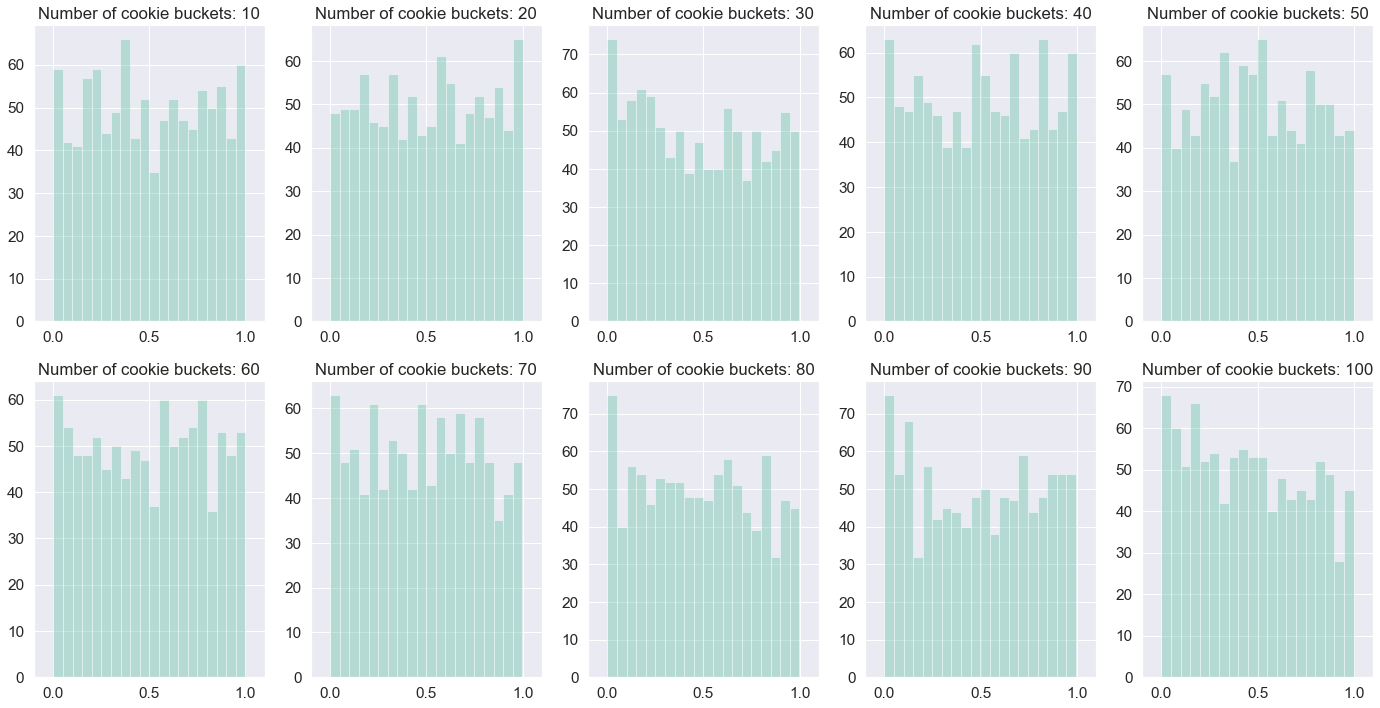

In [24]:
plt.figure(figsize=[24,12])
for i, cur_number_of_buckets in enumerate(cand_num_of_cookie_buckets):
    plt.subplot(2, 5, i+1).set_title('Number of cookie buckets: {:d}'.format(cur_number_of_buckets))
    sns.distplot(one_cor_p_vals_shapiro_95[i],bins=20,norm_hist=False, kde=False)
    plt.xlim([-0.1,1.1])


### one corrupted/ 99th

In [25]:
one_cor_p_vals_shapiro_99=list()
one_cor_rej_results_shapiro_99=list()

In [26]:
for cookie_bucket in cand_num_of_cookie_buckets:
    one_cor_p_vals_shapiro_99 +=[[]]
    one_cor_rej_results_shapiro_99 +=[[]]

In [27]:
for cur_ind, cur_num_of_cookie_buckets in enumerate(cand_num_of_cookie_buckets):
    for i in range(num_of_sims):
        dataset_treat, dataset_control=generate_data_single_corrupted_exp_bucket_level([1000,1000],[600,300],cur_num_of_cookie_buckets,bins_boundaries)

        # bin raw data and place the clients into cookie buckets
        bucketed_data_treat = pd.DataFrame(dataset_treat)
        bucketed_data_control = pd.DataFrame(dataset_control)
        
        #compute pseudovalues
        pseudo_vals = compute_pseudovals_jackknife(bucketed_data_treat,bucketed_data_control,bins_boundaries,0.99)
        #perform normality test
        p_val = shapiro(pseudo_vals)[1]
        #store results
        one_cor_p_vals_shapiro_99[cur_ind] +=[p_val]
        if p_val <= threshold:
            one_cor_rej_results_shapiro_99[cur_ind]+=[1]
        else:
            one_cor_rej_results_shapiro_99[cur_ind]+=[0]

In [28]:
avg_one_cor_rej_res_mixture_99 = np.array([np.mean(cur_num_of_cookie_buckets) for cur_num_of_cookie_buckets in one_cor_rej_results_shapiro_99])
std_one_cor_rej_res_mixture_99 = np.array([np.std(cur_num_of_cookie_buckets) / np.sqrt(num_of_sims) for cur_num_of_cookie_buckets in one_cor_rej_results_shapiro_99])

Text(0.5, 1.0, 'Average rejection rate')

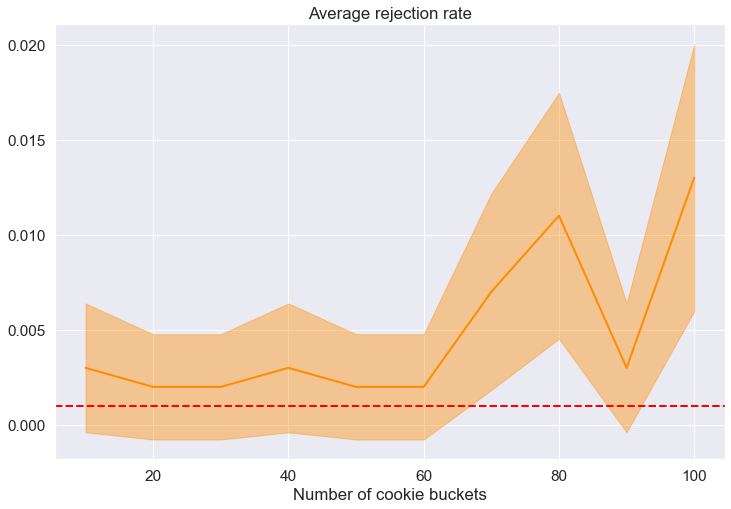

In [29]:
plt.plot(cand_num_of_cookie_buckets, avg_one_cor_rej_res_mixture_99, color='DarkOrange')

plt.fill_between(cand_num_of_cookie_buckets,avg_one_cor_rej_res_mixture_99 - 1.96 * std_one_cor_rej_res_mixture_99,
    avg_one_cor_rej_res_mixture_99 + 1.96*std_one_cor_rej_res_mixture_99, color='DarkOrange', alpha=0.4)


plt.axhline(threshold, color='red', linestyle='dashed')
plt.xlabel('Number of cookie buckets')
plt.title('Average rejection rate')

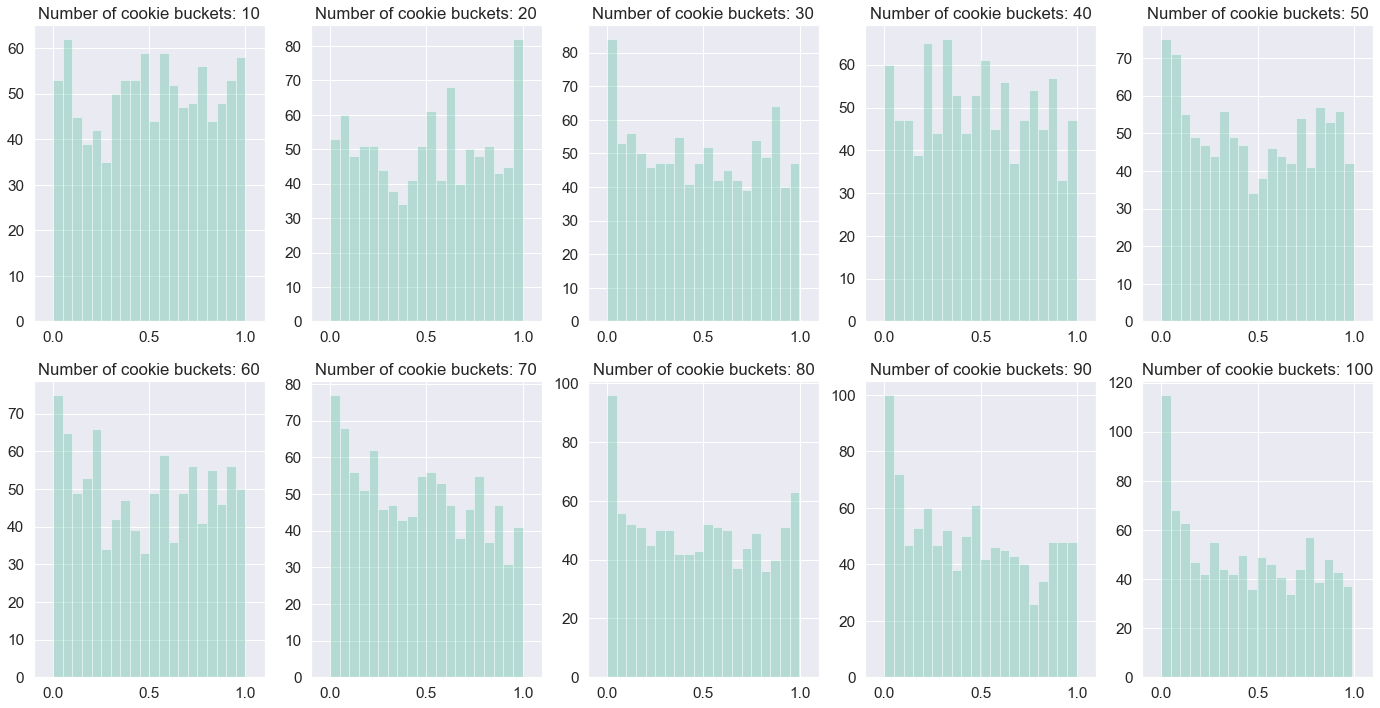

In [30]:
plt.figure(figsize=[24,12])
for i, cur_number_of_buckets in enumerate(cand_num_of_cookie_buckets):
    plt.subplot(2, 5, i+1).set_title('Number of cookie buckets: {:d}'.format(cur_number_of_buckets))
    sns.distplot(one_cor_p_vals_shapiro_99[i],bins=20,norm_hist=False, kde=False)
    plt.xlim([-0.1,1.1])
